# Stock Price Prediction with LSTM and Comparative Analysis
**Dataset:** AMD historical daily prices

This notebook builds on the previous version by adding:
- Comparative baseline (naïve persistence)
- Ablation study over sequence length and hidden units
- Computational complexity stats (parameter count & training time)
- Clear presentation of results via tables and figures
- Discussion on over‑/under‑fitting and mitigation strategies

---

In [166]:

import pandas as pd, numpy as np, os, math, time, itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
plt.rcParams['figure.figsize']=(12,6)

## Loading data

In [167]:

DATA_PATH='AMD.csv'  # adjust path as needed
assert os.path.exists(DATA_PATH), "CSV not found"
df=pd.read_csv(DATA_PATH, parse_dates=['Date']).sort_values('Date')


## Visualize raw data

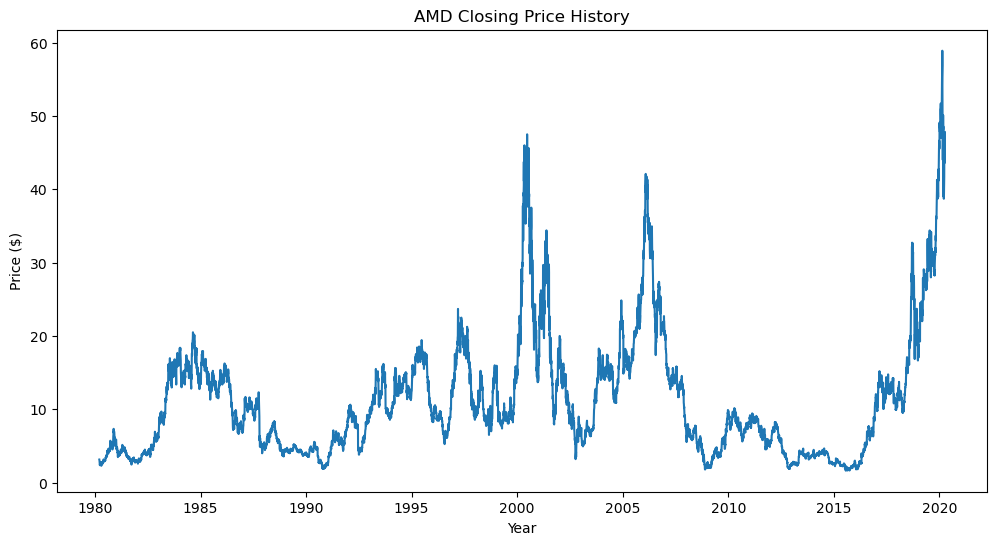

In [168]:

plt.plot(df['Date'], df['Close'])
plt.title('AMD Closing Price History')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.show()


In [169]:

def create_sequences(array, seq_len):
    x,y=[],[]
    for i in range(seq_len, len(array)):
        x.append(array[i-seq_len:i,0])
        y.append(array[i,0])
    return np.array(x), np.array(y)

def build_lstm(seq_len, units):
    model = Sequential([
        Input(shape=(seq_len, 1)),  # Use Input layer to specify the input shape
        LSTM(units, return_sequences=True),
        Dropout(0.2),
        LSTM(units),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [170]:

close_vals=df[['Close']].values
train_size=int(len(close_vals)*0.8)
y_actual=close_vals[train_size:]
y_pred_persist=close_vals[train_size-1:-1]
rmse_persist=math.sqrt(mean_squared_error(y_actual,y_pred_persist))
mae_persist=mean_absolute_error(y_actual,y_pred_persist)
print(f"Persistence baseline -> RMSE:{rmse_persist:.4f} MAE:{mae_persist:.4f}")


Persistence baseline -> RMSE:0.6219 MAE:0.2920


## Default LSTM model (seq_len=60, units=50)

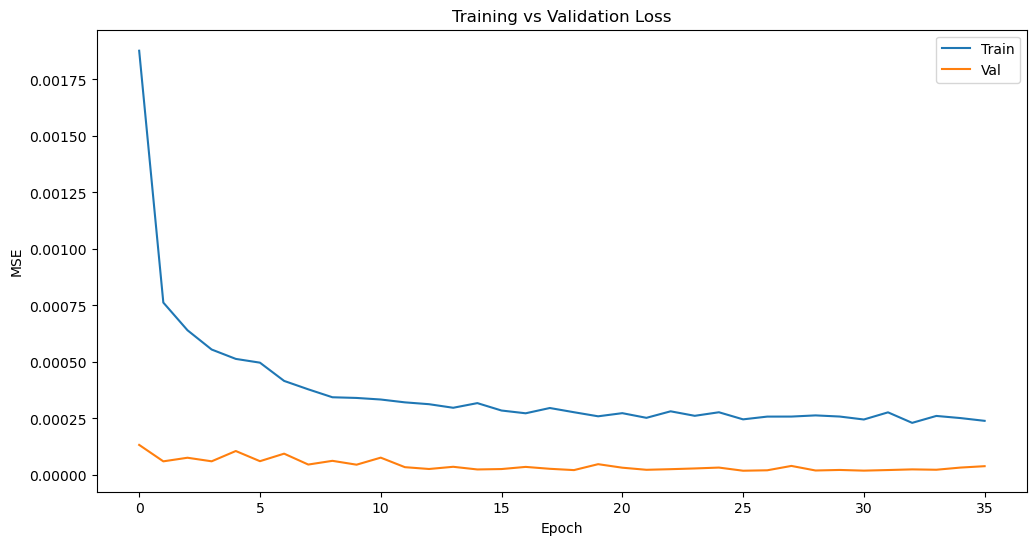

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
LSTM RMSE:0.7541  MAE:0.4146


In [171]:

SEQ_LEN=60
UNITS=50
scaler=MinMaxScaler()
scaled=scaler.fit_transform(close_vals)
X,y=create_sequences(scaled, SEQ_LEN)
X=X.reshape((X.shape[0],X.shape[1],1))
split=int(0.8*len(X))
X_train,X_test=X[:split],X[split:]
y_train,y_test=y[:split],y[split:]

model=build_lstm(SEQ_LEN,UNITS)
es=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
start=time.time()
hist=model.fit(X_train,y_train,validation_split=0.1,epochs=100,batch_size=32,callbacks=[es],verbose=0)
train_time=time.time()-start

# Training loss plot
plt.plot(hist.history['loss'],label='Train')
plt.plot(hist.history['val_loss'],label='Val')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Evaluate
pred=model.predict(X_test)
pred_inv=scaler.inverse_transform(pred)
y_test_inv=scaler.inverse_transform(y_test.reshape(-1,1))
rmse_lstm=math.sqrt(mean_squared_error(y_test_inv,pred_inv))
mae_lstm=mean_absolute_error(y_test_inv,pred_inv)
print(f'LSTM RMSE:{rmse_lstm:.4f}  MAE:{mae_lstm:.4f}')



### Overfitting / Underfitting Analysis

Compare the training and validation loss curves above:

- If validation loss diverges upward while training loss keeps decreasing, over‑fitting is present.

- If both curves plateau at high loss and do not improve, the model is under‑fitting.



**Mitigations** (for over‑fitting): early stopping (already used), dropout (already used), more data, simpler model, stronger regularization.



### LSTM Predicted vs Actual price 

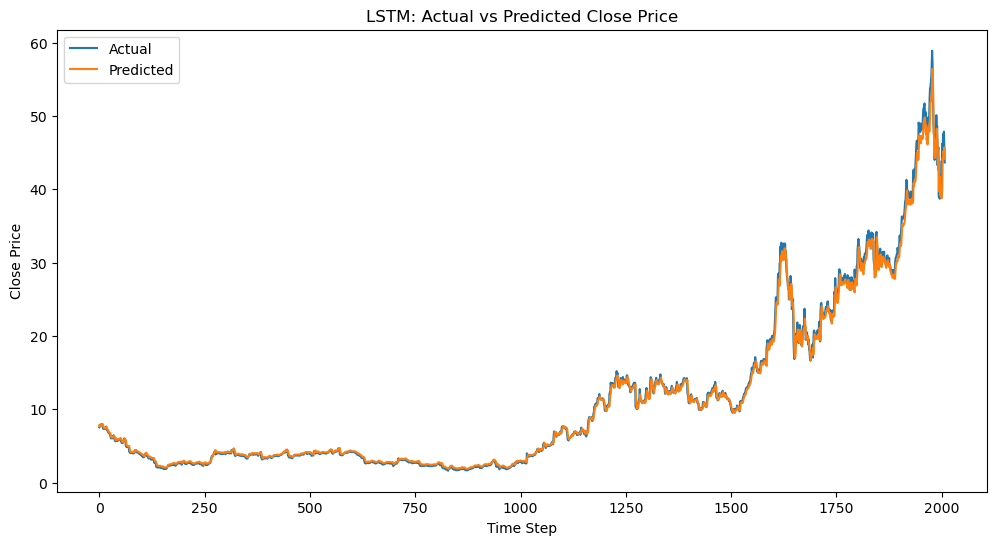

In [172]:
plt.plot(y_test_inv, label='Actual')
plt.plot(pred_inv, label='Predicted')
plt.title('LSTM: Actual vs Predicted Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Ablation study

In [173]:
from tensorflow.keras.optimizers import Adam

def run_lstm_experiment(seq_len, units, batch_size, learning_rate):
    # Scale the data
    scaled = scaler.fit_transform(close_vals)
    X, y = create_sequences(scaled, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    # Split data into train/test
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    # Build the model
    model = build_lstm(seq_len, units)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    
    # Train the model
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    start = time.time()
    hist = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=batch_size,
                     callbacks=[es], verbose=0)
    train_time = time.time() - start
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    return rmse, mae, train_time, hist.history['loss'], hist.history['val_loss']

In [174]:
# Experiment 1: Varying Sequence Length
for seq_len in [30, 60, 120]:
    rmse, mae, train_time, train_loss, val_loss = run_lstm_experiment(seq_len, UNITS, 32, 0.001)
    print(f"SEQ_LEN={seq_len} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, Training Time: {train_time:.2f}s")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
SEQ_LEN=30 -> RMSE: 0.0115, MAE: 0.0055, Training Time: 141.59s
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
SEQ_LEN=60 -> RMSE: 0.0111, MAE: 0.0053, Training Time: 170.82s
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
SEQ_LEN=120 -> RMSE: 0.0119, MAE: 0.0057, Training Time: 364.38s


In [175]:
# Experiment 2: Varying Number of Units
for units in [50, 100, 200]:
    rmse, mae, train_time, train_loss, val_loss = run_lstm_experiment(60, units, 32, 0.001)
    print(f"UNITS={units} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, Training Time: {train_time:.2f}s")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
UNITS=50 -> RMSE: 0.0115, MAE: 0.0055, Training Time: 255.31s
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
UNITS=100 -> RMSE: 0.0126, MAE: 0.0064, Training Time: 315.54s
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
UNITS=200 -> RMSE: 0.0122, MAE: 0.0062, Training Time: 256.27s


In [176]:
# Experiment 3: Varying Learning Rate
for lr in [0.001, 0.0005, 0.0001]:
    rmse, mae, train_time, train_loss, val_loss = run_lstm_experiment(60, UNITS, 32, lr)
    print(f"Learning Rate={lr} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, Training Time: {train_time:.2f}s")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Learning Rate=0.001 -> RMSE: 0.0127, MAE: 0.0061, Training Time: 243.11s
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Learning Rate=0.0005 -> RMSE: 0.0126, MAE: 0.0061, Training Time: 309.18s
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Learning Rate=0.0001 -> RMSE: 0.0146, MAE: 0.0076, Training Time: 368.27s


In [177]:
# Experiment 4: Varying Batch Size
for batch_size in [32, 64, 128]:
    rmse, mae, train_time, train_loss, val_loss = run_lstm_experiment(60, UNITS, batch_size, 0.001)
    print(f"Batch Size={batch_size} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, Training Time: {train_time:.2f}s")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Batch Size=32 -> RMSE: 0.0114, MAE: 0.0054, Training Time: 213.38s
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Batch Size=64 -> RMSE: 0.0112, MAE: 0.0053, Training Time: 180.53s
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Batch Size=128 -> RMSE: 0.0116, MAE: 0.0058, Training Time: 194.88s


## Random Forest model

In [178]:
# Create the target column
df['Target'] = df['Close'].shift(-1)

# Drop rows with any NaNs
df = df.dropna()

# Feature and target columns
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Target'].values

# Train-test split (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [187]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
import math

# Create the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Cross-validation
cross_val_rmse = np.mean(np.sqrt(-cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')))

print(f'Random Forest RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}')
print(f"Cross-validation: {cross_val_rmse:.4f}")

Random Forest RMSE: 1.1062, MAE: 0.4567
Cross-validation: 0.6054


### Random forest Predict vs Actual price

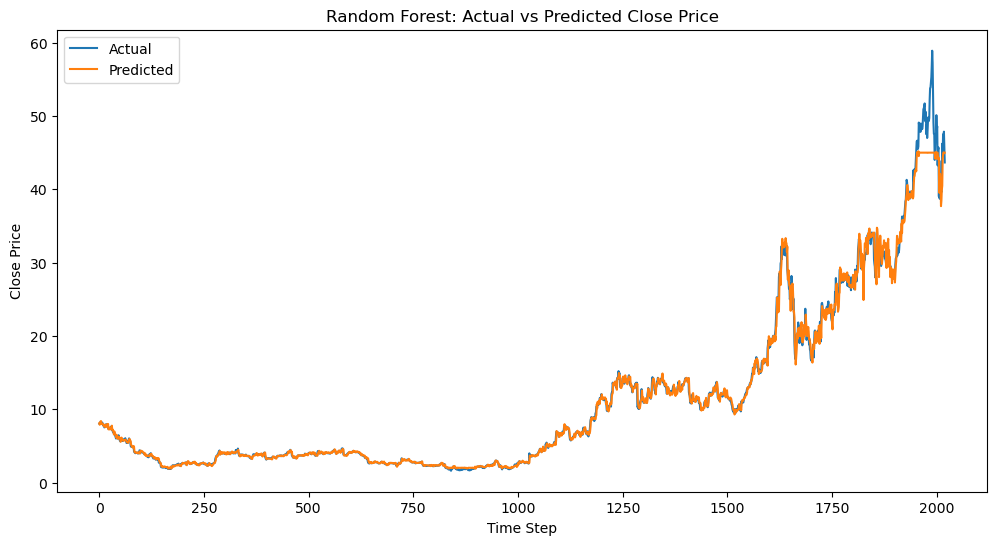

In [182]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred_rf, label='Predicted')
plt.title('Random Forest: Actual vs Predicted Close Price')
plt.xlabel('Time Step')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### Ablation study


### Overfitting / Underfitting Analysis

Compare the RMSE and Cross_val above:

- If RMSE or Cross_val significantly low compare to the other, potential over‑fitting.

- If both Cross_val and RMSE are high, it suggests the model is not learning the patterns in the data well enough, potential under-fitting.



**Mitigations** (for over‑fitting): tune hyperparameters (max depth, min sample leaf,...), more data, stronger regularization.

